<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/beras_medium2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fc3e8407820>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.beras_kualitas_medium_ii.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


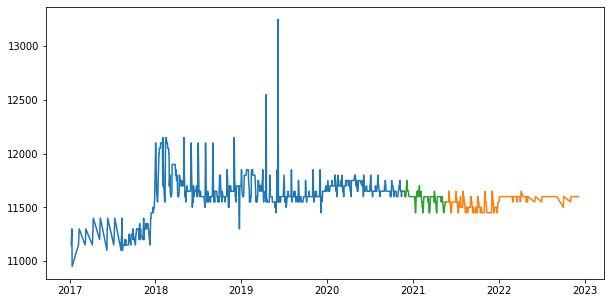

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_beras_medium2_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 45ms/step - loss: 0.0824 - mae: 0.2854 - mape: 89.3608 - val_loss: 0.1273 - val_mae: 0.3300 - val_mape: 7966049.0000
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0496 - mae: 0.2207 - mape: 69.0076 - val_loss: 0.0941 - val_mae: 0.2842 - val_mape: 14284734.0000
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0296 - mae: 0.1697 - mape: 52.9568 - val_loss: 0.0732 - val_mae: 0.2504 - val_mape: 19130200.0000
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0176 - mae: 0.1301 - mape: 40.4955 - val_loss: 0.0597 - val_mae: 0.2268 - val_mape: 22911866.0000
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0105 - mae: 0.0994 - mape: 30.8039 - val_loss: 0.0509 - val_mae: 0.2086 - val_mape: 25828646.0000
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0757 - mape: 23.3794 - val_loss: 0.0452 - val_

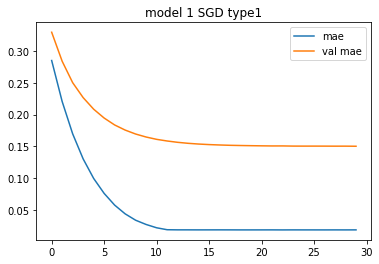

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
134.4257 1.1675695 146.77921078528118


,date,actual,prediction
0,2021-05-20,11550,11680.717773
1,2021-05-21,11550,11682.126953
2,2021-05-24,11550,11680.592773
3,2021-05-25,11550,11681.901367
4,2021-05-27,11550,11680.178711
...,...,...,...
229,2022-11-02,11600,11677.797852
230,2022-11-03,11600,11676.812500
231,2022-11-04,11600,11677.613281
232,2022-12-01,11600,11676.865234


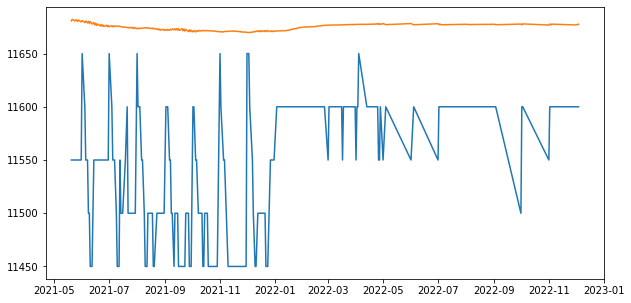

In [ ]:
prediction = forecast_predict(model, test_beras_medium2_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_beras_medium2 = pd.DataFrame()
data_new_beras_medium2['date'] = y_test
data_new_beras_medium2['actual'] = x_test
data_new_beras_medium2['prediction'] = data_result
data_new_beras_medium2.to_csv('beras_medium2_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_beras_medium2.date, data_new_beras_medium2.actual)
plt.plot(data_new_beras_medium2.date, data_new_beras_medium2.prediction)
data_new_beras_medium2

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0404 - mape: 12.1210 - val_loss: 0.0331 - val_mae: 0.1528 - val_mape: 34781784.0000
Epoch 2/30
718/718 [==============================] - 7s 10ms/step - loss: 0.0037 - mae: 0.0406 - mape: 12.1802 - val_loss: 0.0334 - val_mae: 0.1539 - val_mape: 34611624.0000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0037 - mae: 0.0400 - mape: 11.9481 - val_loss: 0.0332 - val_mae: 0.1529 - val_mape: 34765292.0000
Epoch 4/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0037 - mae: 0.0403 - mape: 12.0734 - val_loss: 0.0331 - val_mae: 0.1527 - val_mape: 34800244.0000
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0037 - mae: 0.0405 - mape: 12.1381 - val_loss: 0.0335 - val_mae: 0.1548 - val_mape: 34470644.0000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0037 - mae: 0.0404 - mape: 12.1143 - val_loss: 0.0335

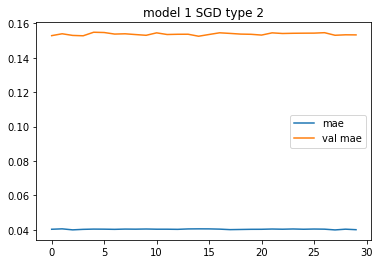

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
119.01568 1.0340267 132.7834747695473


,date,actual,prediction
0,2021-05-20,11550,11680.717773
1,2021-05-21,11550,11682.126953
2,2021-05-24,11550,11680.592773
3,2021-05-25,11550,11681.901367
4,2021-05-27,11550,11680.178711
...,...,...,...
229,2022-11-02,11600,11677.797852
230,2022-11-03,11600,11676.812500
231,2022-11-04,11600,11677.613281
232,2022-12-01,11600,11676.865234


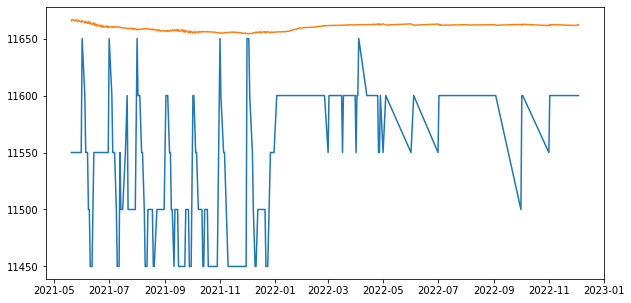

In [ ]:
win_size1 = 60
test_beras_medium2_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_beras_medium2_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_beras_medium2_1 = pd.DataFrame()
data_new_beras_medium2_1['actual'] = x_test
data_new_beras_medium2_1['prediction'] = data_result_1
data_new_beras_medium2_1.to_csv('beras_medium2_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_medium2_1.actual)
plt.plot(y_test, data_new_beras_medium2_1.prediction)
data_new_beras_medium2

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0024 - mae: 0.0277 - mape: 8.7227 - val_loss: 0.0336 - val_mae: 0.1549 - val_mape: 34455668.0000
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0271 - mape: 8.4860 - val_loss: 0.0337 - val_mae: 0.1556 - val_mape: 34340648.0000
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0270 - mape: 8.4343 - val_loss: 0.0338 - val_mae: 0.1560 - val_mape: 34276372.0000
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0269 - mape: 8.3984 - val_loss: 0.0339 - val_mae: 0.1564 - val_mape: 34213016.0000
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0265 - mape: 8.2185 - val_loss: 0.0340 - val_mae: 0.1568 - val_mape: 34156220.0000
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0265 - mape: 8.2240 - val_loss: 0.0339 - val_mae: 0

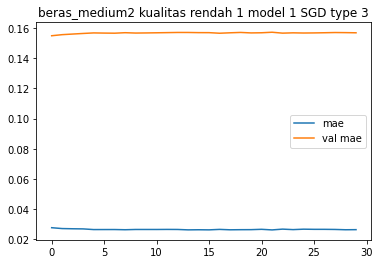

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('beras_medium2 kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
108.660225 0.9442738 123.42943802786675


,actual,prediction
0,11550,11655.075195
1,11550,11656.407227
2,11550,11654.954102
3,11550,11656.158203
4,11550,11654.481445
...,...,...
229,11600,11651.932617
230,11600,11650.944336
231,11600,11651.747070
232,11600,11650.998047


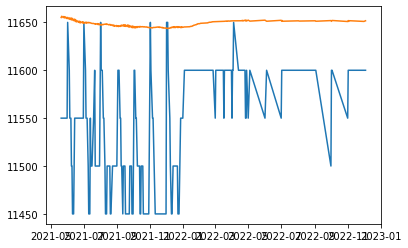

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_beras_medium2_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_beras_medium2_2 = pd.DataFrame()
# data_new_beras_medium21['date'] = date_test
data_new_beras_medium2_2['actual'] = x_test
data_new_beras_medium2_2['prediction'] = data_result_2
data_new_beras_medium2_2.to_csv('beras_medium2_model1_sgd_type3')

plt.plot(y_test, data_new_beras_medium2_2.actual)
plt.plot(y_test, data_new_beras_medium2_2.prediction)
data_new_beras_medium2_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 37ms/step - loss: 0.0724 - mae: 0.2668 - mape: 83.4880 - val_loss: 0.1046 - val_mae: 0.2998 - val_mape: 12290114.0000
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0257 - mae: 0.1513 - mape: 47.0393 - val_loss: 0.0389 - val_mae: 0.1755 - val_mape: 31461646.0000
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0012 - mae: 0.0278 - mape: 8.6291 - val_loss: 0.0304 - val_mae: 0.1433 - val_mape: 38641560.0000
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 4.8630e-04 - mae: 0.0187 - mape: 5.8216 - val_loss: 0.0305 - val_mae: 0.1436 - val_mape: 38371252.0000
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 4.6721e-04 - mae: 0.0181 - mape: 5.6340 - val_loss: 0.0304 - val_mae: 0.1433 - val_mape: 38632972.0000
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 4.6579e-04 - mae: 0.0180 - mape: 5.6117 - val_loss: 0.030

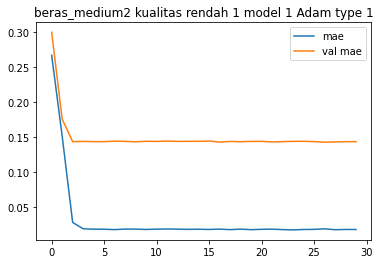

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('beras_medium2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
80.07908 0.6961432 95.55459009121435


,actual,prediction
0,11550,11664.184570
1,11550,11664.656250
2,11550,11663.473633
3,11550,11663.486328
4,11550,11661.961914
...,...,...
229,11600,11636.300781
230,11600,11635.930664
231,11600,11636.078125
232,11600,11635.860352


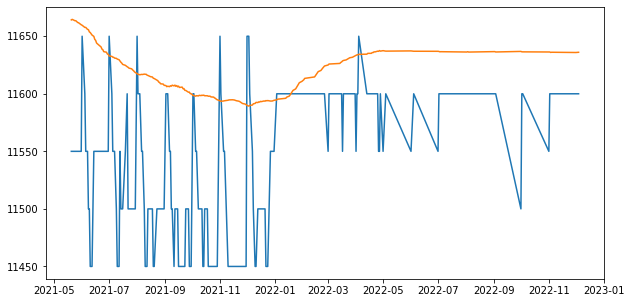

In [ ]:
prediction_a = forecast_predict(model_a, test_beras_medium2_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_beras_medium2_a = pd.DataFrame()
# data_new_beras_medium21['date'] = date_test
data_new_beras_medium2_a['actual'] = x_test
data_new_beras_medium2_a['prediction'] = data_result_a
data_new_beras_medium2_a.to_csv('beras_medium2_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_beras_medium2_a.actual)
plt.plot(y_test, data_new_beras_medium2_a.prediction)
data_new_beras_medium2_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0039 - mae: 0.0400 - mape: 11.8766 - val_loss: 0.0316 - val_mae: 0.1454 - val_mape: 37096656.0000
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0037 - mae: 0.0379 - mape: 11.2295 - val_loss: 0.0319 - val_mae: 0.1457 - val_mape: 36922752.0000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0036 - mae: 0.0382 - mape: 11.3743 - val_loss: 0.0313 - val_mae: 0.1449 - val_mape: 37640900.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0036 - mae: 0.0386 - mape: 11.4904 - val_loss: 0.0312 - val_mae: 0.1448 - val_mape: 37851196.0000
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0036 - mae: 0.0381 - mape: 11.3444 - val_loss: 0.0316 - val_mae: 0.1455 - val_mape: 37412768.0000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0036 - mae: 0.0384 - mape: 11.4309 - val_loss: 0.0322 

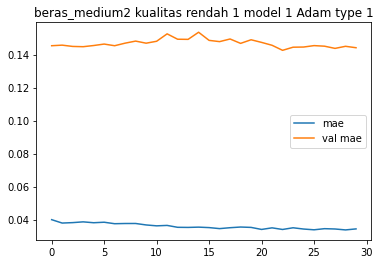

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('beras_medium2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
172.43326 1.4966754 181.22943848889452


,actual,prediction
0,11550,11715.604492
1,11550,11716.543945
2,11550,11714.294922
3,11550,11714.250000
4,11550,11710.893555
...,...,...
229,11600,11712.981445
230,11600,11712.606445
231,11600,11712.809570
232,11600,11712.708008


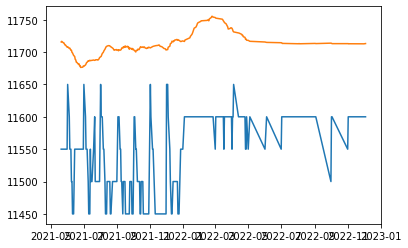

In [ ]:
prediction_a1 = forecast_predict(model_a, test_beras_medium2_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_beras_medium2_a1 = pd.DataFrame()
data_new_beras_medium2_a1['actual'] = x_test
data_new_beras_medium2_a1['prediction'] = data_result_a1
data_new_beras_medium2_a1.to_csv('beras_medium2_model1_adam_type2.csv')

plt.plot(y_test, data_new_beras_medium2_a1.actual)
plt.plot(y_test, data_new_beras_medium2_a1.prediction)
data_new_beras_medium2_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0023 - mae: 0.0234 - mape: 7.1225 - val_loss: 0.0303 - val_mae: 0.1429 - val_mape: 39832524.0000
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0244 - mape: 7.5617 - val_loss: 0.0309 - val_mae: 0.1442 - val_mape: 38730328.0000
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0238 - mape: 7.2776 - val_loss: 0.0302 - val_mae: 0.1428 - val_mape: 39885580.0000
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0235 - mape: 7.1857 - val_loss: 0.0300 - val_mae: 0.1422 - val_mape: 40460752.0000
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0239 - mape: 7.3768 - val_loss: 0.0311 - val_mae: 0.1446 - val_mape: 38498088.0000
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0239 - mape: 7.3266 - val_loss: 0.0305 - val_mae: 0

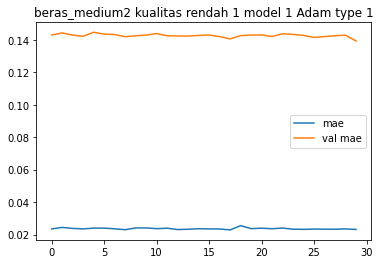

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('beras_medium2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
110.946 0.96326506 119.95142652991876


,actual,prediction
0,11550,11688.501953
1,11550,11688.969727
2,11550,11687.142578
3,11550,11687.007812
4,11550,11684.571289
...,...,...
229,11600,11675.949219
230,11600,11675.572266
231,11600,11674.683594
232,11600,11674.597656


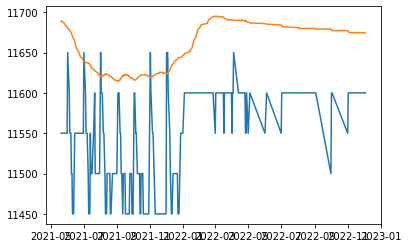

In [ ]:
prediction_a2 = forecast_predict(model_a, test_beras_medium2_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_beras_medium2_a2 = pd.DataFrame()
# data_new_beras_medium21['date'] = date_test
data_new_beras_medium2_a2['actual'] = x_test
data_new_beras_medium2_a2['prediction'] = data_result_a2
data_new_beras_medium2_a2.to_csv('beras_medium2_model1_adam_type3.csv')

plt.plot(y_test, data_new_beras_medium2_a2.actual)
plt.plot(y_test, data_new_beras_medium2_a2.prediction)
data_new_beras_medium2_a2

## model 1

### Adam

In [11]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.0444 - mae: 0.1845 - mape: 57.2481 - val_loss: 0.0313 - val_mae: 0.1336 - val_mape: 47036312.0000
Epoch 2/15
44/44 [==============================] - 1s 23ms/step - loss: 7.7418e-04 - mae: 0.0221 - mape: 6.9044 - val_loss: 0.0297 - val_mae: 0.1415 - val_mape: 40731540.0000
Epoch 3/15
44/44 [==============================] - 1s 23ms/step - loss: 4.5976e-04 - mae: 0.0176 - mape: 5.5066 - val_loss: 0.0299 - val_mae: 0.1421 - val_mape: 40186064.0000
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 5.0432e-04 - mae: 0.0182 - mape: 5.6740 - val_loss: 0.0295 - val_mae: 0.1399 - val_mape: 41991936.0000
Epoch 5/15
44/44 [==============================] - 1s 23ms/step - loss: 4.6477e-04 - mae: 0.0177 - mape: 5.5348 - val_loss: 0.0298 - val_mae: 0.1419 - val_mape: 40375360.0000
Epoch 6/15
44/44 [==============================] - 1s 23ms/step - loss: 5.0929e-04 - mae: 0.0184 - mape: 5.7533 - val_loss

17/17 [==============================] - 0s 8ms/step - loss: 0.0935 - mae: 0.2808 - mape: 38.9538


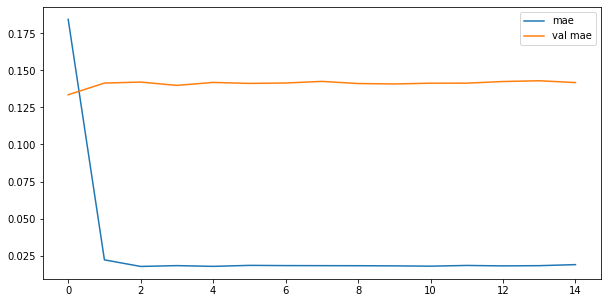

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_beras_medium2_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_beras_medium21 = pd.DataFrame()
data_new_beras_medium21['actual'] = x_test
data_new_beras_medium21['prediction'] = data_result1
data_new_beras_medium21.to_csv('beras_medium2_model2_adam_type1.csv')

data_new_beras_medium21

131/131 [==============================] - 2s 8ms/step
52.533855 0.4552116 59.306726783703674


,actual,prediction
0,11550,11542.121094
1,11550,11542.333984
2,11550,11542.052734
3,11550,11542.269531
4,11550,11541.898438
...,...,...
229,11600,11536.987305
230,11600,11536.882812
231,11600,11536.952148
232,11600,11536.848633


In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_beras_medium21['actual'], '-o')
plt.plot(range(len(x_test)), data_new_beras_medium21['prediction'], '-o')

#### Type 2

In [12]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 24s 15ms/step - loss: 0.0102 - mae: 0.0547 - mape: 15.7256 - val_loss: 0.0295 - val_mae: 0.1410 - val_mape: 40237664.0000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0039 - mae: 0.0397 - mape: 11.7587 - val_loss: 0.0306 - val_mae: 0.1437 - val_mape: 38500652.0000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0382 - mape: 11.3124 - val_loss: 0.0308 - val_mae: 0.1442 - val_mape: 38742768.0000
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0036 - mae: 0.0374 - mape: 11.1175 - val_loss: 0.0324 - val_mae: 0.1473 - val_mape: 37008424.0000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0035 - mae: 0.0380 - mape: 11.3000 - val_loss: 0.0321 - val_mae: 0.1469 - val_mape: 37741272.0000
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0035 - mae: 0.0373 - mape: 11.1645 - val_loss: 0.034

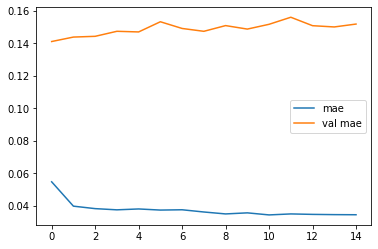

In [13]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 6ms/step
103.26242 0.89691615 114.09161871468693


,actual,prediction
0,11550,11682.772461
1,11550,11687.857422
2,11550,11681.040039
3,11550,11685.981445
4,11550,11678.236328
...,...,...
229,11600,11658.144531
230,11600,11653.758789
231,11600,11657.224609
232,11600,11653.587891


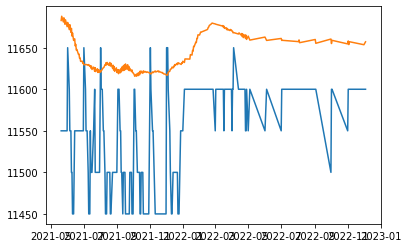

In [14]:
prediction1_1 = forecast_predict(model1, test_beras_medium2_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_beras_medium21_1 = pd.DataFrame()
data_new_beras_medium21_1['actual'] = x_test
data_new_beras_medium21_1['prediction'] = data_result1_1
data_new_beras_medium21_1.to_csv('beras_medium2_model2_adam_type2.csv')

plt.plot(y_test, data_new_beras_medium21_1.actual)
plt.plot(y_test, data_new_beras_medium21_1.prediction)
data_new_beras_medium21_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 24s 63ms/step - loss: 0.0190 - mae: 0.0907 - mape: 28.9627 - val_loss: 0.0298 - val_mae: 0.1416 - val_mape: 40731128.0000
Epoch 2/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0024 - mae: 0.0247 - mape: 7.5925 - val_loss: 0.0300 - val_mae: 0.1423 - val_mape: 40213884.0000
Epoch 3/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0244 - mape: 7.4576 - val_loss: 0.0298 - val_mae: 0.1379 - val_mape: 43968808.0000
Epoch 4/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0256 - mape: 7.9151 - val_loss: 0.0297 - val_mae: 0.1411 - val_mape: 41280600.0000
Epoch 5/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0259 - mape: 7.9864 - val_loss: 0.0308 - val_mae: 0.1443 - val_mape: 38641684.0000
Epoch 6/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0244 - mape: 7.4881 - val_loss: 0.0299 - val_mae:

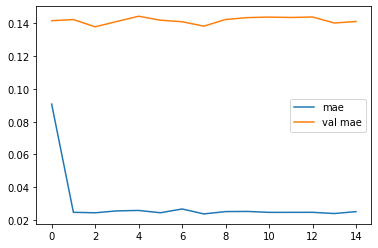

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
75.509384 0.6560936 89.11154899373312


,actual,prediction
0,11550,11682.751953
1,11550,11684.840820
2,11550,11682.236328
3,11550,11684.445312
4,11550,11681.182617
...,...,...
229,11600,11641.514648
230,11600,11640.324219
231,11600,11640.888672
232,11600,11639.958008


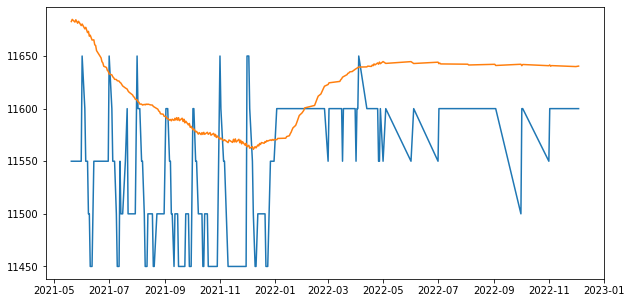

In [ ]:
prediction1_2 = forecast_predict(model1, test_beras_medium2_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_beras_medium21_2 = pd.DataFrame()
data_new_beras_medium21_2['actual'] = x_test
data_new_beras_medium21_2['prediction'] = data_result1_2
data_new_beras_medium21_2.to_csv('beras_medium2_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_medium21_2.actual)
plt.plot(y_test, data_new_beras_medium21_2.prediction)

data_new_beras_medium21_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 48ms/step - loss: 0.0952 - mae: 0.3073 - mape: 96.2654 - val_loss: 0.1531 - val_mae: 0.3603 - val_mape: 3701743.5000
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0705 - mae: 0.2642 - mape: 82.7047 - val_loss: 0.1273 - val_mae: 0.3300 - val_mape: 7900438.5000
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0531 - mae: 0.2290 - mape: 71.6502 - val_loss: 0.1079 - val_mae: 0.3045 - val_mape: 11417548.0000
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0398 - mae: 0.1979 - mape: 61.8615 - val_loss: 0.0925 - val_mae: 0.2818 - val_mape: 14543293.0000
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0298 - mae: 0.1709 - mape: 53.3399 - val_loss: 0.0804 - val_mae: 0.2621 - val_mape: 17261750.0000
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0223 - mae: 0.1474 - mape: 45.9550 - val_loss: 0.0710 - val_ma

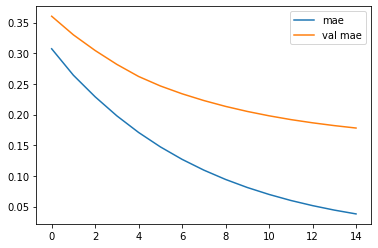

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
53.876144 0.4669168 60.387295752345544


,actual,prediction
0,11550,11534.998047
1,11550,11535.027344
2,11550,11535.003906
3,11550,11535.025391
4,11550,11535.005859
...,...,...
229,11600,11534.746094
230,11600,11534.728516
231,11600,11534.738281
232,11600,11534.730469


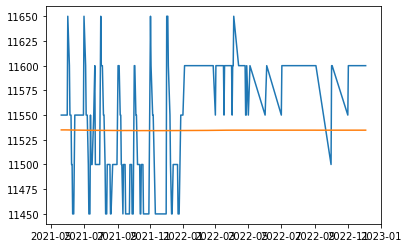

In [ ]:
prediction1_a = forecast_predict(model1_a, test_beras_medium2_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_beras_medium21_a = pd.DataFrame()
data_new_beras_medium21_a['actual'] = x_test
data_new_beras_medium21_a['prediction'] = data_result1_a
data_new_beras_medium21_a.to_csv('beras_medium2_model2_sgd_type1.csv')


plt.plot(y_test, data_new_beras_medium21_a.actual)
plt.plot(y_test, data_new_beras_medium21_a.prediction)

data_new_beras_medium21_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0041 - mae: 0.0391 - mape: 11.1942 - val_loss: 0.0342 - val_mae: 0.1580 - val_mape: 33839948.0000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0405 - mape: 12.0651 - val_loss: 0.0340 - val_mae: 0.1571 - val_mape: 34023444.0000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0406 - mape: 12.1209 - val_loss: 0.0337 - val_mae: 0.1558 - val_mape: 34227924.0000
Epoch 4/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0037 - mae: 0.0406 - mape: 12.1690 - val_loss: 0.0338 - val_mae: 0.1562 - val_mape: 34174084.0000
Epoch 5/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0037 - mae: 0.0405 - mape: 12.0974 - val_loss: 0.0337 - val_mae: 0.1556 - val_mape: 34278620.0000
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0405 - mape: 12.1210 - val_loss: 0.0336 

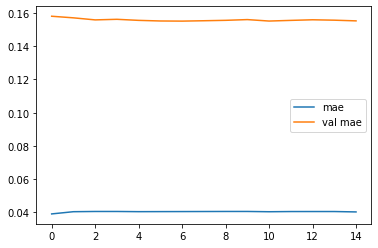

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
52.18806 0.45264697 60.25134123896123


,actual,prediction
0,11550,11543.967773
1,11550,11544.000000
2,11550,11543.971680
3,11550,11544.005859
4,11550,11543.971680
...,...,...
229,11600,11543.723633
230,11600,11543.706055
231,11600,11543.715820
232,11600,11543.703125


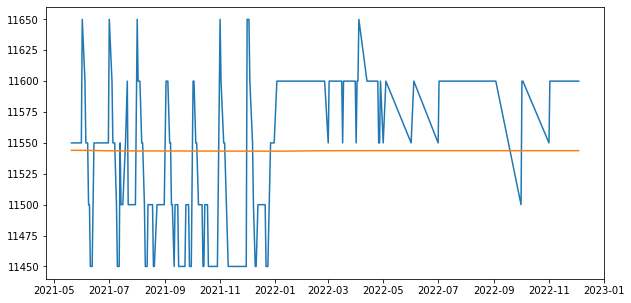

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_beras_medium2_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_beras_medium21_a1 = pd.DataFrame()
data_new_beras_medium21_a1['actual'] = x_test
data_new_beras_medium21_a1['prediction'] = data_result1_a1
data_new_beras_medium21_a1.to_csv('beras_medium2_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_medium21_a1.actual)
plt.plot(y_test, data_new_beras_medium21_a1.prediction)
data_new_beras_medium21_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0024 - mae: 0.0285 - mape: 9.0562 - val_loss: 0.0339 - val_mae: 0.1564 - val_mape: 34162248.0000
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0024 - mae: 0.0280 - mape: 8.8268 - val_loss: 0.0341 - val_mae: 0.1573 - val_mape: 34016096.0000
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0024 - mae: 0.0275 - mape: 8.6373 - val_loss: 0.0342 - val_mae: 0.1580 - val_mape: 33899864.0000
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0024 - mae: 0.0272 - mape: 8.5148 - val_loss: 0.0343 - val_mae: 0.1585 - val_mape: 33819360.0000
Epoch 5/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0024 - mae: 0.0271 - mape: 8.4703 - val_loss: 0.0344 - val_mae: 0.1587 - val_mape: 33785488.0000
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0024 - mae: 0.0270 - mape: 8.4255 - val_loss: 0.0344 - val_mae: 0

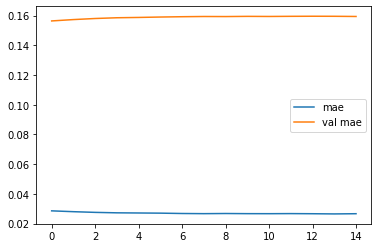

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
52.526905 0.45551187 60.17347967543509


,actual,prediction
0,11550,11542.175781
1,11550,11542.207031
2,11550,11542.178711
3,11550,11542.210938
4,11550,11542.177734
...,...,...
229,11600,11541.928711
230,11600,11541.910156
231,11600,11541.920898
232,11600,11541.908203


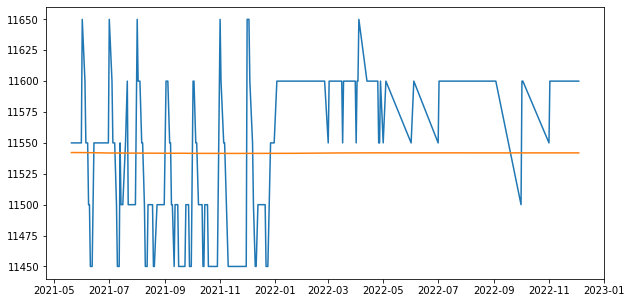

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_beras_medium2_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_beras_medium21_a2 = pd.DataFrame()
data_new_beras_medium21_a2['actual'] = x_test
data_new_beras_medium21_a2['prediction'] = data_result1_a2
data_new_beras_medium21_a2.to_csv('beras_medium2_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_medium21_a2.actual)
plt.plot(y_test, data_new_beras_medium21_a2.prediction)

data_new_beras_medium21_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 34ms/step - loss: 0.0895 - mae: 0.2978 - mape: 93.2948 - val_loss: 0.1439 - val_mae: 0.3499 - val_mape: 5168133.5000
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0635 - mae: 0.2505 - mape: 78.3548 - val_loss: 0.1151 - val_mae: 0.3142 - val_mape: 10097219.0000
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0447 - mae: 0.2098 - mape: 65.6151 - val_loss: 0.0945 - val_mae: 0.2849 - val_mape: 14136521.0000
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0316 - mae: 0.1761 - mape: 54.9845 - val_loss: 0.0794 - val_mae: 0.2605 - val_mape: 17513016.0000
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0224 - mae: 0.1475 - mape: 45.9777 - val_loss: 0.0683 - val_mae: 0.2422 - val_mape: 20359454.0000
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0158 - mae: 0.1236 - mape: 38.4507 - val_loss: 0.0600 - val_m

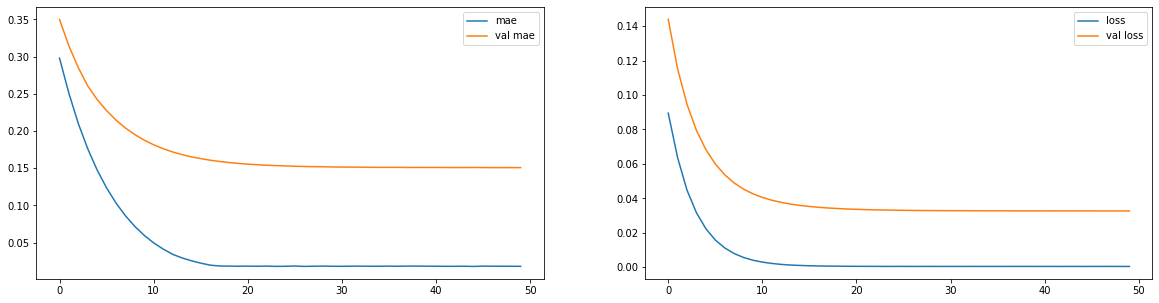

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
51.956985 0.45069712 60.390368288587624


,actual,prediction
0,11550,11545.684570
1,11550,11545.724609
2,11550,11545.719727
3,11550,11545.744141
4,11550,11545.666016
...,...,...
229,11600,11545.082031
230,11600,11545.032227
231,11600,11545.090820
232,11600,11545.072266


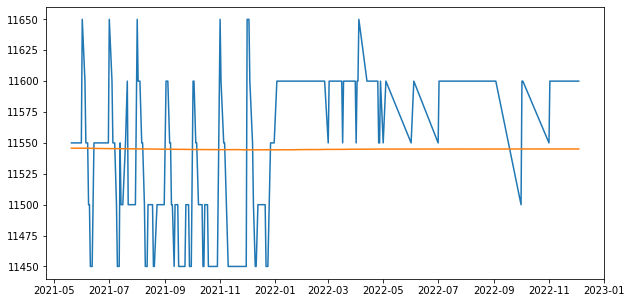

In [ ]:
prediction2 = forecast_predict(model2, test_beras_medium2_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_beras_medium22 = pd.DataFrame()
data_new_beras_medium22['actual'] = x_test
data_new_beras_medium22['prediction'] = data_result2
data_new_beras_medium22.to_csv('beras_medium2_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_medium22.actual)
plt.plot(y_test, data_new_beras_medium22.prediction)
data_new_beras_medium22

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0038 - mae: 0.0414 - mape: 12.4572 - val_loss: 0.0332 - val_mae: 0.1533 - val_mape: 34594564.0000
Epoch 2/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0038 - mae: 0.0408 - mape: 12.2066 - val_loss: 0.0331 - val_mae: 0.1530 - val_mape: 34629388.0000
Epoch 3/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0038 - mae: 0.0408 - mape: 12.2249 - val_loss: 0.0332 - val_mae: 0.1534 - val_mape: 34573172.0000
Epoch 4/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0038 - mae: 0.0407 - mape: 12.1845 - val_loss: 0.0334 - val_mae: 0.1544 - val_mape: 34415248.0000
Epoch 5/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0038 - mae: 0.0410 - mape: 12.2690 - val_loss: 0.0333 - val_mae: 0.1539 - val_mape: 34494092.0000
Epoch 6/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0037 - mae: 0.0409 - mape: 12.2635 - val_loss: 0.0335 

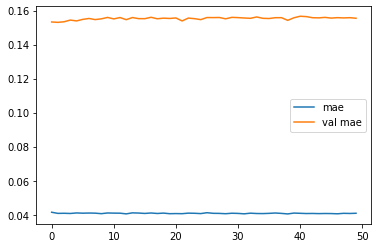

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_beras_medium2_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_beras_medium22_1 = pd.DataFrame()
data_new_beras_medium22_1['actual'] = x_test
data_new_beras_medium22_1['prediction'] = data_result2_1
data_new_beras_medium22_1.to_csv('beras_medium2_model3_sgd_type2.csv')

data_new_beras_medium22

199/199 [==============================] - 1s 4ms/step
52.256077 0.4532362 60.30630432879199


,actual,prediction
0,11550,11545.684570
1,11550,11545.724609
2,11550,11545.719727
3,11550,11545.744141
4,11550,11545.666016
...,...,...
229,11600,11545.082031
230,11600,11545.032227
231,11600,11545.090820
232,11600,11545.072266


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0025 - mae: 0.0287 - mape: 9.1103 - val_loss: 0.0339 - val_mae: 0.1568 - val_mape: 34013784.0000
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0024 - mae: 0.0281 - mape: 8.8706 - val_loss: 0.0342 - val_mae: 0.1580 - val_mape: 33832304.0000
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0024 - mae: 0.0276 - mape: 8.6424 - val_loss: 0.0343 - val_mae: 0.1585 - val_mape: 33745964.0000
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0024 - mae: 0.0277 - mape: 8.6691 - val_loss: 0.0344 - val_mae: 0.1589 - val_mape: 33683580.0000
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0024 - mae: 0.0272 - mape: 8.4994 - val_loss: 0.0345 - val_mae: 0.1594 - val_mape: 33605772.0000
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0024 - mae: 0.0272 - mape: 8.4800 - val_loss: 0.0345 - val_mae: 0

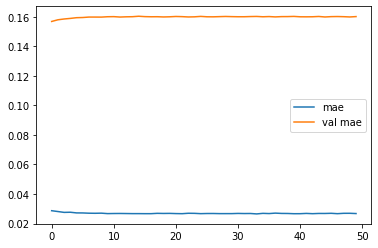

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_beras_medium2_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_beras_medium22_2 = pd.DataFrame()
data_new_beras_medium22_2['actual'] = x_test
data_new_beras_medium22_2['prediction'] = data_result2_2
data_new_beras_medium22_2.to_csv('beras_medium2_model3_sgd-type3.csv')

data_new_beras_medium22_2

181/181 [==============================] - 1s 4ms/step
52.58918 0.45605236 60.23023048322578


,actual,prediction
0,11550,11541.970703
1,11550,11542.000977
2,11550,11541.941406
3,11550,11541.981445
4,11550,11541.955078
...,...,...
229,11600,11541.805664
230,11600,11541.791016
231,11600,11541.794922
232,11600,11541.782227


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 1s 19ms/step - loss: 4.4707e-04 - mae: 0.0162 - mape: 5.0229 - val_loss: 0.0289 - val_mae: 0.1399 - val_mape: 39895308.0000
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 3.8615e-04 - mae: 0.0151 - mape: 4.6934 - val_loss: 0.0289 - val_mae: 0.1399 - val_mape: 39894728.0000
Epoch 3/50
44/44 [==============================] - 1s 16ms/step - loss: 3.8031e-04 - mae: 0.0149 - mape: 4.6764 - val_loss: 0.0291 - val_mae: 0.1404 - val_mape: 39405668.0000
Epoch 4/50
44/44 [==============================] - 1s 16ms/step - loss: 3.7908e-04 - mae: 0.0146 - mape: 4.5374 - val_loss: 0.0292 - val_mae: 0.1406 - val_mape: 39258228.0000
Epoch 5/50
44/44 [==============================] - 1s 16ms/step - loss: 3.8143e-04 - mae: 0.0150 - mape: 4.6831 - val_loss: 0.0293 - val_mae: 0.1409 - val_mape: 39053912.0000
Epoch 6/50
44/44 [==============================] - 1s 16ms/step - loss: 3.8568e-04 - mae: 0.0151 - mape: 4.7189 - val_l

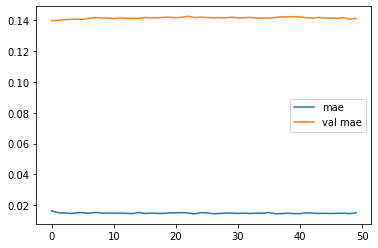

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_beras_medium2_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_beras_medium22_a = pd.DataFrame()
data_new_beras_medium22_a['actual'] = x_test
data_new_beras_medium22_a['prediction'] = data_result2_a
data_new_beras_medium22_a.to_csv('beras_medium2_model3_adam-type1.csv')

data_new_beras_medium22_a

131/131 [==============================] - 1s 6ms/step
47.021748 0.40807208 55.685983074176754


,actual,prediction
0,11550,11541.862305
1,11550,11541.459961
2,11550,11541.259766
3,11550,11541.611328
4,11550,11541.987305
...,...,...
229,11600,11554.428711
230,11600,11554.361328
231,11600,11554.095703
232,11600,11553.343750


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0042 - mae: 0.0408 - mape: 12.0827 - val_loss: 0.0307 - val_mae: 0.1433 - val_mape: 37406272.0000
Epoch 2/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0038 - mae: 0.0400 - mape: 11.9354 - val_loss: 0.0317 - val_mae: 0.1449 - val_mape: 36273104.0000
Epoch 3/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0036 - mae: 0.0386 - mape: 11.5311 - val_loss: 0.0308 - val_mae: 0.1431 - val_mape: 37272644.0000
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0036 - mae: 0.0392 - mape: 11.6738 - val_loss: 0.0316 - val_mae: 0.1443 - val_mape: 36315588.0000
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0035 - mae: 0.0386 - mape: 11.5313 - val_loss: 0.0327 - val_mae: 0.1500 - val_mape: 35264956.0000
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0035 - mae: 0.0380 - mape: 11.3623 - val_loss: 0.0329 

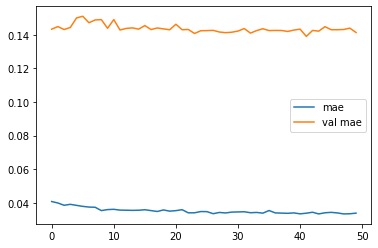

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
50.955097 0.44221902 60.742777830732685


,actual,prediction
0,11550,11550.693359
1,11550,11550.430664
2,11550,11550.270508
3,11550,11550.544922
4,11550,11550.557617
...,...,...
229,11600,11548.057617
230,11600,11547.921875
231,11600,11548.004883
232,11600,11548.091797


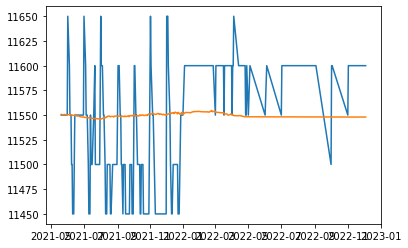

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_beras_medium2_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_beras_medium22_a1 = pd.DataFrame()
data_new_beras_medium22_a1['actual'] = x_test
data_new_beras_medium22_a1['prediction'] = data_result2_a1
data_new_beras_medium22_a1.to_csv('beras_medium2_model3_adam-type2.csv')

plt.plot(y_test, data_new_beras_medium22_a1.actual)
plt.plot(y_test, data_new_beras_medium22_a1.prediction)
data_new_beras_medium22_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

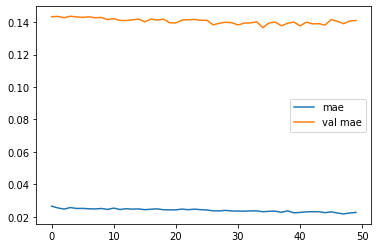

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
46.94735 0.40741464 55.661967614088844


,actual,prediction
0,11550,11542.598633
1,11550,11542.936523
2,11550,11543.385742
3,11550,11542.979492
4,11550,11542.546875
...,...,...
229,11600,11555.273438
230,11600,11554.583008
231,11600,11554.298828
232,11600,11554.220703


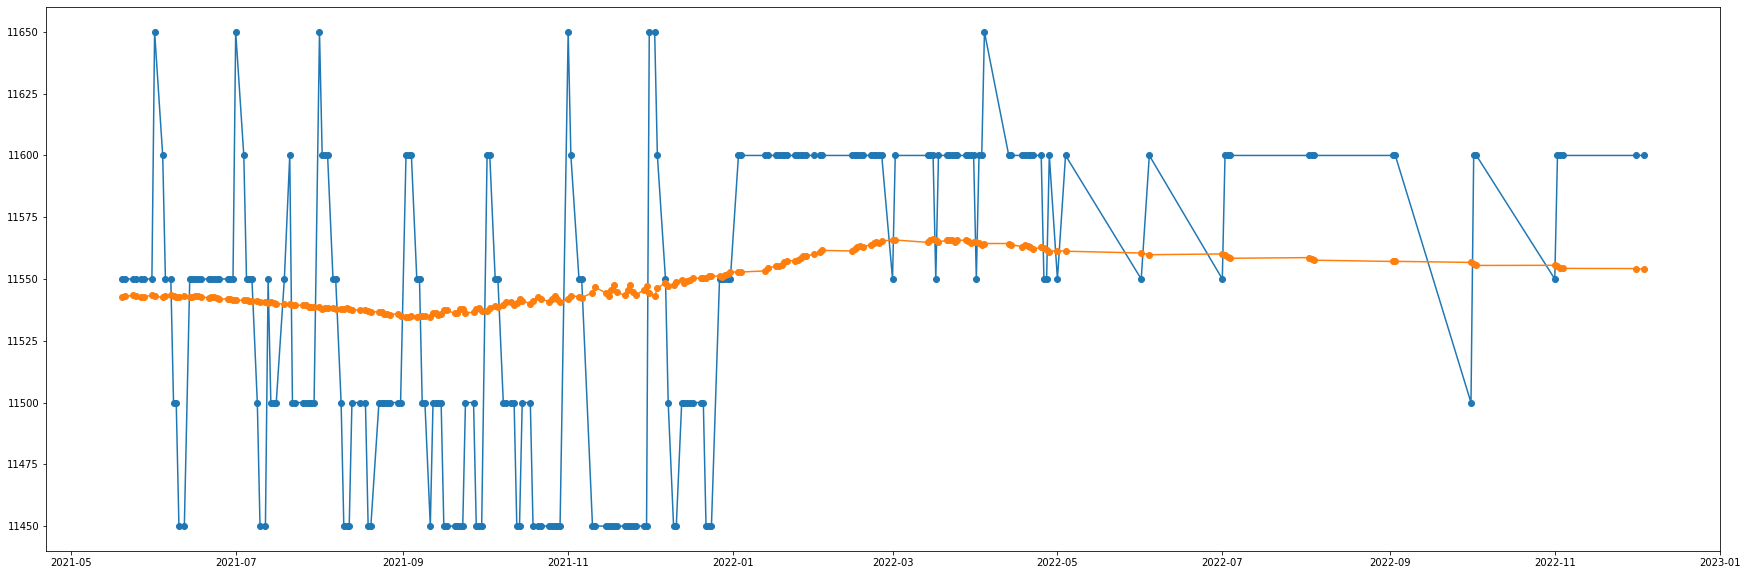

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_beras_medium2_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_beras_medium22_a2 = pd.DataFrame()
data_new_beras_medium22_a2['actual'] = x_test
data_new_beras_medium22_a2['prediction'] = data_result2_a2
data_new_beras_medium22_a2.to_csv('beras_medium2_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_beras_medium22_a2.actual, '-o')
plt.plot(y_test,data_new_beras_medium22_a2.prediction, '-o')
data_new_beras_medium22_a2